# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load Data

In [3]:
df = pd.read_csv('/Users/aayushchand/Air_Quality_XGBoost/Data/datasets.csv')
df.head()

,aod,lst,soil_moisture,pm10,pm25,O3,NDVI,elevation,surface_pressure
0,1.033,25.53,0.321072,112.0,182.0,0.131271,0.164740,1353,83796.535156
1,0.173,24.39,0.333978,50.0,98.0,0.114578,0.148204,1353,84271.480469
2,0.158,24.39,0.333978,50.0,98.0,0.114578,0.148204,1353,84271.480469
3,0.181,25.27,0.331775,36.0,89.0,0.110911,0.147098,1353,84351.183594
4,0.284,25.27,0.331775,36.0,89.0,0.110911,0.147098,1353,84351.183594


# Outlier Treatment

In [4]:
for col in df.columns:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    df[col] = np.clip(df[col], Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)

# Feature Scaling

In [5]:
X = df.drop(['pm10', 'pm25'], axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_scaled

array([[ 2.18778742,  0.2581244 ,  0.50150773, ...,  0.79058984,
         1.75441472, -1.01551913],
       [-1.08614761,  0.0566922 ,  0.75587358, ...,  0.51934654,
         1.75441472,  0.50334769],
       [-1.16080975,  0.0566922 ,  0.75587358, ...,  0.51934654,
         1.75441472,  0.50334769],
       ...,
       [-1.01646294, -1.13776535,  0.08418601, ..., -0.1686235 ,
         0.97062214,  0.04292565],
       [ 0.11840165, -1.13776535,  0.08418601, ..., -0.1686235 ,
         0.97062214,  0.04292565],
       [-1.40968357, -0.8550535 , -0.08515158, ..., -0.18181199,
         0.97062214, -0.6617548 ]])

# Define Hyperparameter Grid

In [7]:
param_grid = {
    'n_estimators': [600, 800, 1000],
    'max_depth': [6],
    'learning_rate': [0.1, 0.15],
    'subsample': [0.6, 0.7]
}

# Model Training and Evaluation for PM10

In [8]:
y = df['pm10']
label = 'PM10'

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

In [10]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.1, 0.15], 'max_depth': [6],
                         'n_estimators': [600, 800, 1000],
                         'subsample': [0.6, 0.7]},
             scoring='neg_mean_squared_error', verbose=1)

In [11]:
best_model = grid_search.best_estimator_

print("\nBest Hyperparameters:")
print(grid_search.best_params_)


Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 800, 'subsample': 0.6}


# Predictions and Metrics for PM10

In [12]:
preds = best_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"\n{label} XGBoost Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


PM10 XGBoost Evaluation:
MAE: 5.80
RMSE: 9.57
R²: 0.92


# Feature Importance for PM10

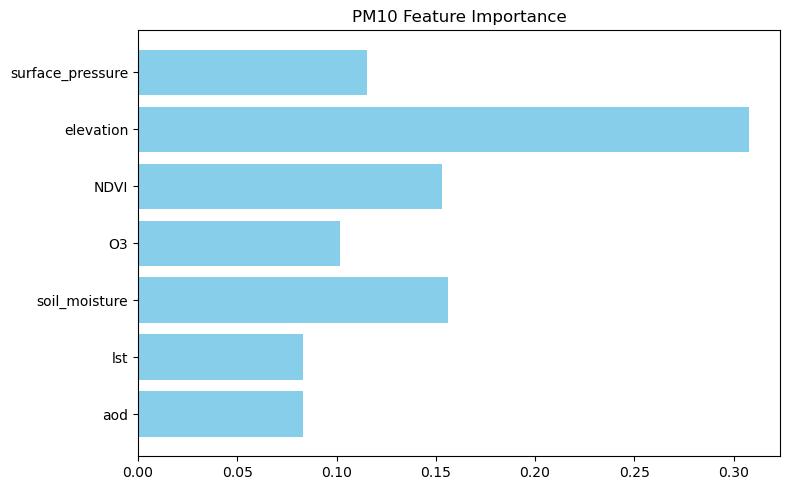

In [13]:
plt.figure(figsize=(8, 5))
plt.barh(X.columns, best_model.feature_importances_, color='skyblue')
plt.title(f"{label} Feature Importance")
plt.tight_layout()
plt.show()

# Prediction vs Actual Plot for PM10

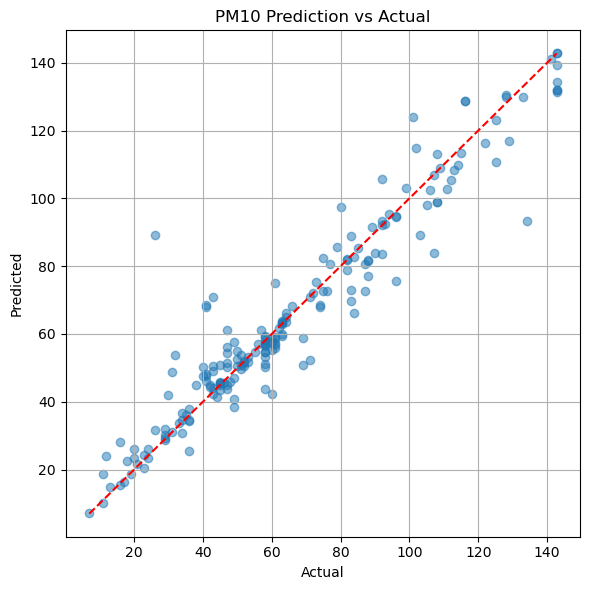

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"{label} Prediction vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Learning Curve for PM10

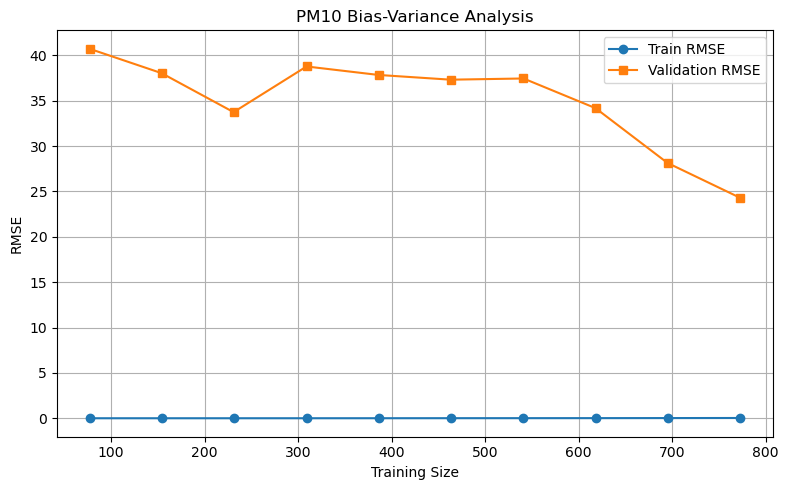

In [15]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_scaled, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
plt.plot(train_sizes, val_rmse, marker='s', label='Validation RMSE')
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title(f"{label} Bias-Variance Analysis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Training and Evaluation for PM2.5

In [16]:
y = df['pm25']
label = 'PM2.5'

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [17]:
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1
)

In [18]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.1, 0.15], 'max_depth': [6],
                         'n_estimators': [600, 800, 1000],
                         'subsample': [0.6, 0.7]},
             scoring='neg_mean_squared_error', verbose=1)

In [19]:
best_model = grid_search.best_estimator_

print("\n Best Hyperparameters:")
print(grid_search.best_params_)


 Best Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 800, 'subsample': 0.7}


In [20]:
preds = best_model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"\n{label} XGBoost Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


PM2.5 XGBoost Evaluation:
MAE: 7.56
RMSE: 12.73
R²: 0.87


# Visualization for PM2.5

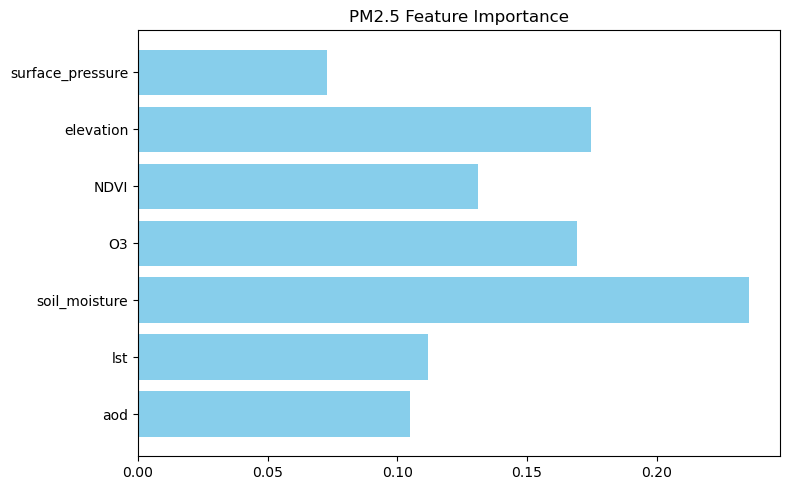

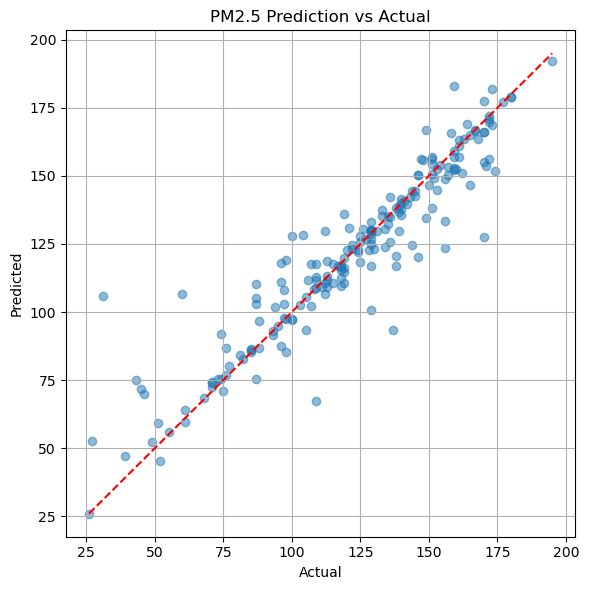

In [21]:
# Feature importance
plt.figure(figsize=(8, 5))
plt.barh(X.columns, best_model.feature_importances_, color='skyblue')
plt.title(f"{label} Feature Importance")
plt.tight_layout()
plt.show()

# Prediction vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"{label} Prediction vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()

# Learning Curve for PM2.5

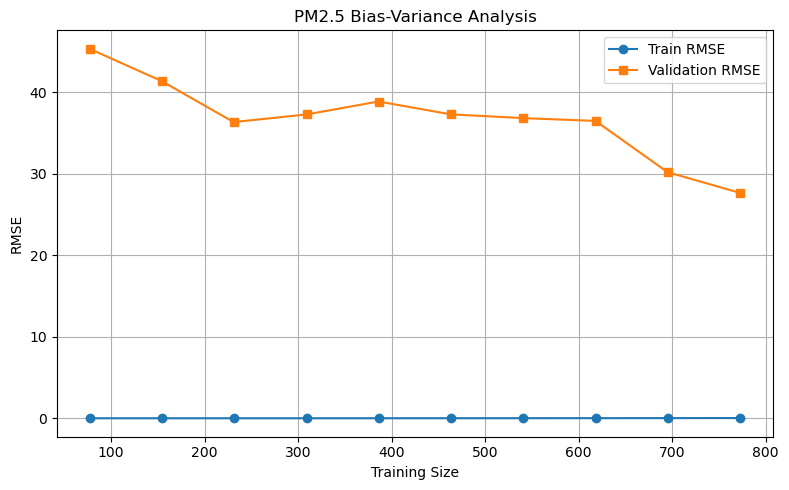

In [22]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_scaled, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
plt.plot(train_sizes, val_rmse, marker='s', label='Validation RMSE')
plt.xlabel("Training Size")
plt.ylabel("RMSE")
plt.title(f"{label} Bias-Variance Analysis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()